In [ ]:
!pip install imutils

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [ ]:
#first create the one empty folder and 
#Intializing the path of that folder
dataset_path = '/content/drive/My Drive/Cdataset'

create two sub folders under empty dataset folder and name it as normal for one folder and covid-19 for other folder 

In [ ]:
%%bash
#Creating two subfolders in dataset folder
#rm -rf dataset
#mkdir -p dataset/covid
#mkdir -p dataset/normal

#Dataset Creating
In this project, data is loaded from two different databases and merged into one folder. Here i am loading covid-19 positive chest X-ray images from Covid-19 chest X ray data base ( i downloaded it from github)

In [ ]:
# Specifing the path of Covid-19 x-ray images dataset
covid19_dataset_path = '/content/drive/My Drive/x-ray'

In [ ]:
# Loading the metadata CSV for the covid-19 chest x-ray images
data_frame = pd.read_csv('/content/drive/My Drive/x-ray/metadata.csv')

In [ ]:
data_frame.head(10)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes
0,2,0.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
1,2,3.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
2,2,5.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
3,2,6.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
4,4,0.0,F,52.0,COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN
5,4,5.0,F,52.0,COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN
6,5,NaN,NaN,NaN,ARDS,NaN,NaN,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,2017,NaN,images,ARDSSevere.png,NaN,https://en.wikipedia.org/wiki/File:ARDSSevere.png,CC BY-SA,Severe ARDS. Person is intubated with an OG in...,NaN
7,6,0.0,NaN,NaN,COVID-19,Y,NaN,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN
8,6,4.0,NaN,NaN,COVID-19,Y,NaN,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN
9,3,4.0,M,74.0,SARS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,AP,X-ray,2004,"Mount Sinai Hospital, Toronto, Ontario, Canada",images,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,NaN,SARS in a 74-year-old man who developed sympto...,NaN


From the above table we can observe, the finding coloum indicates wheather patient is infected by covid 19 or not

In [ ]:

# loop over the rows of the COVID-19 data frame
# creating a loop for covid-19 dataframe and checking each patient finding
#wheather he is suffering from covid-19 or not
for (iter, row_find) in data_frame.iterrows():
    # PA is a medical term
    if row_find["finding"] != "COVID-19" or row_find["view"] != "PA":
        continue

    #Constructing a path to the input images
    imagefiles_Path = os.path.sep.join([covid19_dataset_path, "images", row_find["filename"]])

    
    # If the images not exist with covid-19 continue the loop
    if not os.path.exists(imagefiles_Path):
        continue

    # It extracts the name of file from the image path and concatinating path to the copied image file
    file_name = row_find["filename"].split(os.path.sep)[-1]
    output_Path = os.path.sep.join([f"{dataset_path}/covid", file_name])

    # Copy the covid-19 positive images into image path 
    shutil.copy2(imagefiles_Path, output_Path)

In [ ]:
normal_dataset_path ='/content/drive/My Drive/x-ray/chest_xray'

In [ ]:
no_of_samples = 150

In [10]:
base_Path = os.path.sep.join([normal_dataset_path, "train", "NORMAL"])
imagefiles_Paths = list(paths.list_images(base_Path))

# It shuffles the images randomly 
random.seed(42)
random.shuffle(imagefiles_Paths)
# it selectes the randomly 50 images from the chest x-ray dataset
imagefiles_Paths = imagefiles_Paths[:no_of_samples]

# iterating the each and every image over the imagefiles_path
for (iter, imagefiles_Path) in enumerate(imagefiles_Paths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    file_name = imagefiles_Path.split(os.path.sep)[-1]
    output_Path = os.path.sep.join([f"{dataset_path}/normal", file_name])

    # copy the image
    shutil.copy2(imagefiles_Path, output_Path)

In [11]:
#creating a function to plot the x-ray images
def celldivsion(a, b):
    return -(-a // b)

def plots_images_fromfiles(images_paths, figuresize=(10,5), no_rows=1, titles=None, main_title=None):
    """Plot the images in a grid"""
    figure = plt.figure(figsize=figuresize)
    if main_title is not None: plt.suptitle(main_title, fontsize=10)
    for x in range(len(images_paths)):
        sub_plot = figure.add_subplot(no_rows, celldivsion(len(images_paths), no_rows), x+1)
        sub_plot.axis('Off')
        if titles is not None: sp.set_title(titles[x], fontsize=16)
        image = plt.imread(images_paths[x])
        plt.imshow(image)

In [12]:
#Specifing the path of normal images
normalimages = list(paths.list_images(f"{dataset_path}/normal"))
#Specifing the path of Covid-19 images
covidimages = list(paths.list_images(f"{dataset_path}/covid"))

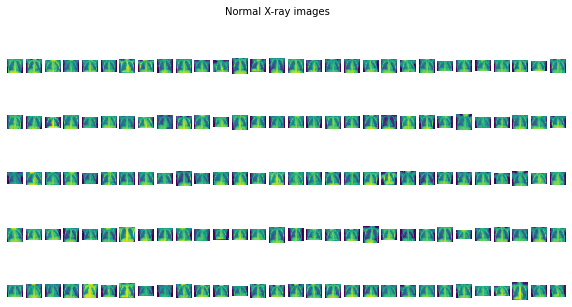

In [13]:
#ploting the normal chest x-ray images
plots_images_fromfiles(normalimages, no_rows=5, main_title="Normal X-ray images")

In [14]:
len(normalimages)

150

In [15]:
len(covidimages)

181

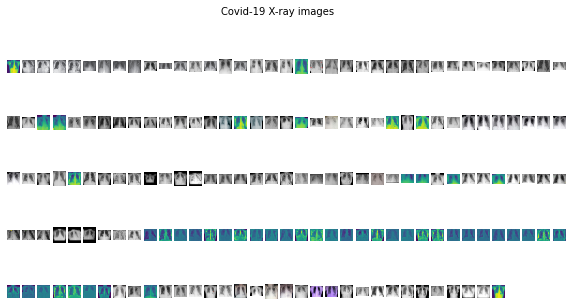

In [16]:
#plotting covid-19 chest x ray images
plots_images_fromfiles(covidimages, no_rows=5, main_title="Covid-19 X-ray images")

In [17]:

# categorizing the data into images and labels
print("[INFO] loading images...")
image_Paths = list(paths.list_images(dataset_path))
img_data = []
class_labels = []

#Iterarting over the image paths 
for imagePath in image_Paths:
    # Class labels are extracted from the file name
    c_label = imagePath.split(os.path.sep)[-2]
    # image is coverted into rgb and reshaped to 224*224 pixels
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    #appending the images into imaga data list
    img_data.append(img)
    #appending the labels into class labels list
    class_labels.append(c_label)


[INFO] loading images...


#Feature Scaling

In [18]:
#performimg features scaling
#converting the image data and labels into numpy array
#Dividing each and every image in the dataset by 255 and coverting the data into [0,1]
#because maximum imgae pixel size is 255
img_data = np.array(img_data)/255.0
class_labels = np.array(class_labels)


In [19]:
# perform one-hot encoding on the class_labels
label = LabelBinarizer()
class_labels = label.fit_transform(class_labels)
class_labels = to_categorical(class_labels)

#Data splitting

In [20]:
#split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(img_data, class_labels, test_size=0.2,random_state=42)

#Data Augumentation

In [21]:
#performing data augumention for rescaling the data
train_Augumentation = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

#Model Creation

In [22]:

#loading the VGG16 deep neural network model from keras
#making top of the model is set off
VGG16_Model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

#Building the head of the model and placeing it on the top of the VGG16 model
Model_head = VGG16_Model.output
#headModel = Conv2D(32,(3,3), activation="relu")(headModel)
#headModel = MaxPooling2D(pool_size=(4,4))(headModel)
Model_head = AveragePooling2D(pool_size=(4, 4))(Model_head)
Model_head = Flatten(name="flatten")(Model_head)
Model_head = Dense(64, activation="relu")(Model_head)
Model_head = Dropout(0.5)(Model_head)
Model_head = Dense(2, activation="softmax")(Model_head)

#placing the head model on the top of the VGG16 model 
# This modle is the actual model we are training
model = Model(inputs=VGG16_Model.input, outputs=Model_head)

# Iterating each and every layer in the VGG16 model and stooping them 
#so they will not be trained or updated during the first training process
for each_layer in VGG16_Model.layers:
    each_layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

#Hyperparameters assigning

In [24]:
#Specifing the learning rate, epochs, and batch size
learning_rate = 1e-3
Epochs=20
Batch_size=64


#Training and Testing 

In [25]:
# compileing the model
opti = Adam(lr=learning_rate, decay=learning_rate / Epochs)
model.compile(loss="binary_crossentropy", optimizer=opti, metrics=["accuracy"])

# train the model
H_Model = model.fit_generator(
    train_Augumentation.flow(X_train, y_train, batch_size=Batch_size),
    steps_per_epoch=len(X_train) // Batch_size,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // Batch_size,
    epochs=Epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
4/4 [==============================] - 4s 1s/step - loss: 0.7427 - accuracy: 0.5350 - val_loss: 0.6230 - val_accuracy: 0.7463
Epoch 2/20
4/4 [==============================] - 2s 438ms/step - loss: 0.6889 - accuracy: 0.5650 - val_loss: 0.5945 - val_accuracy: 0.8209
Epoch 3/20
4/4 [==============================] - 2s 431ms/step - loss: 0.6345 - accuracy: 0.6600 - val_loss: 0.5443 - val_accuracy: 0.8806
Epoch 4/20
4/4 [==============================] - 2s 552ms/step - loss: 0.5851 - accuracy: 0.7109 - val_loss: 0.4988 - val_accuracy: 0.8657
Epoch 5/20
4/4 [==============================] - 2s 580ms/step - loss: 0.5095 - accuracy: 0.7350 - val_loss: 0.4678 - val_accuracy: 0.8358
Epoch 6/20
4/4 [==============================] - 2s 426ms/step - loss: 0.4519 - accuracy: 0.8350 - val_loss: 0.4331 - val_accuracy: 0.8955
Epoch 7/20
4/4 [==============================] - 2s 425ms/step - loss: 0.4480 - accura

#Graphs

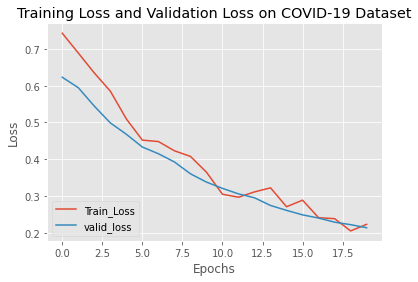

In [26]:
# plot the training loss and accuracy
#Plotting graph for the loss v/s epochs
No_E = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, No_E), H_Model.history["loss"], label="Train_Loss")
plt.plot(np.arange(0, No_E), H_Model.history["val_loss"], label="valid_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

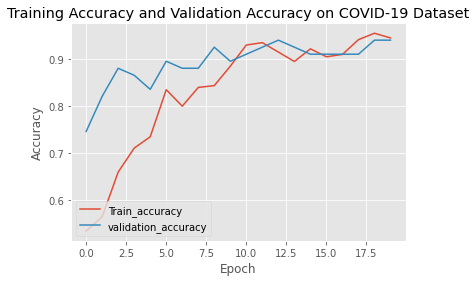

In [27]:
# plot the training loss and accuracy
No_E = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, No_E), H_Model.history["accuracy"], label="Train_accuracy")
plt.plot(np.arange(0, No_E), H_Model.history["val_accuracy"], label="validation_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [28]:
#performing the predictions on the test set
print("[INFO] evaluating network...")
prediction_test = model.predict(X_test, batch_size=Batch_size)
#To every image in the testing set, We finding the index of the label with corresponding
# largest predictred probability
prediction_test = np.argmax(prediction_test, axis=1)
#Displaying the classification report
print(classification_report(y_test.argmax(axis=1), prediction_test, target_names=label.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.97      0.92      0.95        38
      normal       0.90      0.97      0.93        29

    accuracy                           0.94        67
   macro avg       0.94      0.94      0.94        67
weighted avg       0.94      0.94      0.94        67



In [29]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
con_m = confusion_matrix(y_test.argmax(axis=1), prediction_test)
total = sum(sum(con_m))
accuracy = (con_m[0, 0] + con_m[1, 1]) / total
sensitivity = con_m[0, 0] / (con_m[0, 0] + con_m[0, 1])
specificity = con_m[1, 1] / (con_m[1, 0] + con_m[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(" Confussion Matrix is:")
print(con_m)
print("accuracy: {:.4f}".format(accuracy))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

 Confussion Matrix is:
[[35  3]
 [ 1 28]]
accuracy: 0.9403
sensitivity: 0.9211
specificity: 0.9655


In [30]:
# saving the model
model.save('1116540.h5')